In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
import pytensor.tensor as pt
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
# helpers
def binomial(n_samples, theta_like=0.7, seed=20):
    np.random.seed(seed)
    data = np.random.binomial(n_samples, theta_like)
    return data

def load_config(config_file="config.json"):

    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def beta_posterior(successes, trials, alpha_0, beta_0):
    alpha_post = alpha_0 + successes
    beta_post = beta_0 + trials - successes
    mean_post = alpha_post / (alpha_post + beta_post)
    var_post = (alpha_post * beta_post) / ((alpha_post + beta_post) ** 2 * (alpha_post + beta_post + 1))
    return {
        'alpha_post': alpha_post,
        'beta_post': beta_post,
        'mean_post': mean_post,
        'std_post': np.sqrt(var_post)
    }

from scipy.special import expit  # sigmoid

def _logistic_normal_mean_std_mc(mu, sigma, n_samples=10_000, seed=0):
    mu = float(np.squeeze(mu))
    sigma = float(np.squeeze(sigma))
    rng = np.random.default_rng(seed)
    z = rng.normal(loc=mu, scale=sigma, size=n_samples)
    theta = expit(z)
    return float(theta.mean()), float(theta.std(ddof=1))

def _trace_locscale_to_theta_moments(loc_trace, scale_trace, n_samples=10_000, seed=0):
    loc_trace = np.asarray(loc_trace, dtype=float)
    scale_trace = np.asarray(scale_trace, dtype=float)
    out_mean = np.empty(loc_trace.shape[0], dtype=float)
    out_std  = np.empty(loc_trace.shape[0], dtype=float)
    for i in range(loc_trace.shape[0]):
        out_mean[i], out_std[i] = _logistic_normal_mean_std_mc(
            loc_trace[i], scale_trace[i], n_samples=n_samples, seed=seed
        )
    return out_mean, out_std

data_gen = binomial

In [3]:
config_file = "beta_config.json"
config = load_config(config_file)

theta_like = config['theta_like']
alpha_prior = config['alpha_prior']
beta_prior = config['beta_prior']
n_samples = config['n_samples']
grad_samps = config['grad_samps']
max_iters = 100_000
adam_step = config['adam_step']

data = data_gen(n_samples) if n_samples > 0 else 0

In [4]:
def run_model(n_mc_samples = 1, optimizer = 'default', seed = 1):
        

    with pm.Model() as single_model:
        # Define the prior
        theta = pm.Beta('theta', alpha=alpha_prior, beta=beta_prior)

        # Define the likelihood
        y = pm.Binomial('y', n=n_samples, p=theta, observed=data)

        advi = pm.ADVI(random_seed=10)

        tracker = pm.callbacks.Tracker(
            mean=advi.approx.mean.eval,
            std=advi.approx.std.eval,
        )

        if optimizer == 'default':
            approx = advi.fit(
                max_iters, callbacks=[tracker],
                progressbar=True,
                obj_n_mc=n_mc_samples
            )
        else:
            approx = advi.fit(
                max_iters, callbacks=[tracker],
                progressbar=True,
                obj_n_mc=n_mc_samples,
                obj_optimizer=pm.adam(learning_rate=adam_step)
            )
    return tracker['mean'], tracker['std']

single_mus_unc, single_stds_unc = run_model()
multi_mus_unc, multi_stds_unc = run_model(n_mc_samples=100)
adam_single_mus_unc, adam_single_stds_unc = run_model(optimizer='adam')
adam_multi_mus_unc, adam_multi_stds_unc = run_model(n_mc_samples=100, optimizer='adam')


Output()

Finished [100%]: Average Loss = 2.7381


Output()

Finished [100%]: Average Loss = 2.73


Output()

Finished [100%]: Average Loss = 2.7311


Output()

Finished [100%]: Average Loss = 2.7303


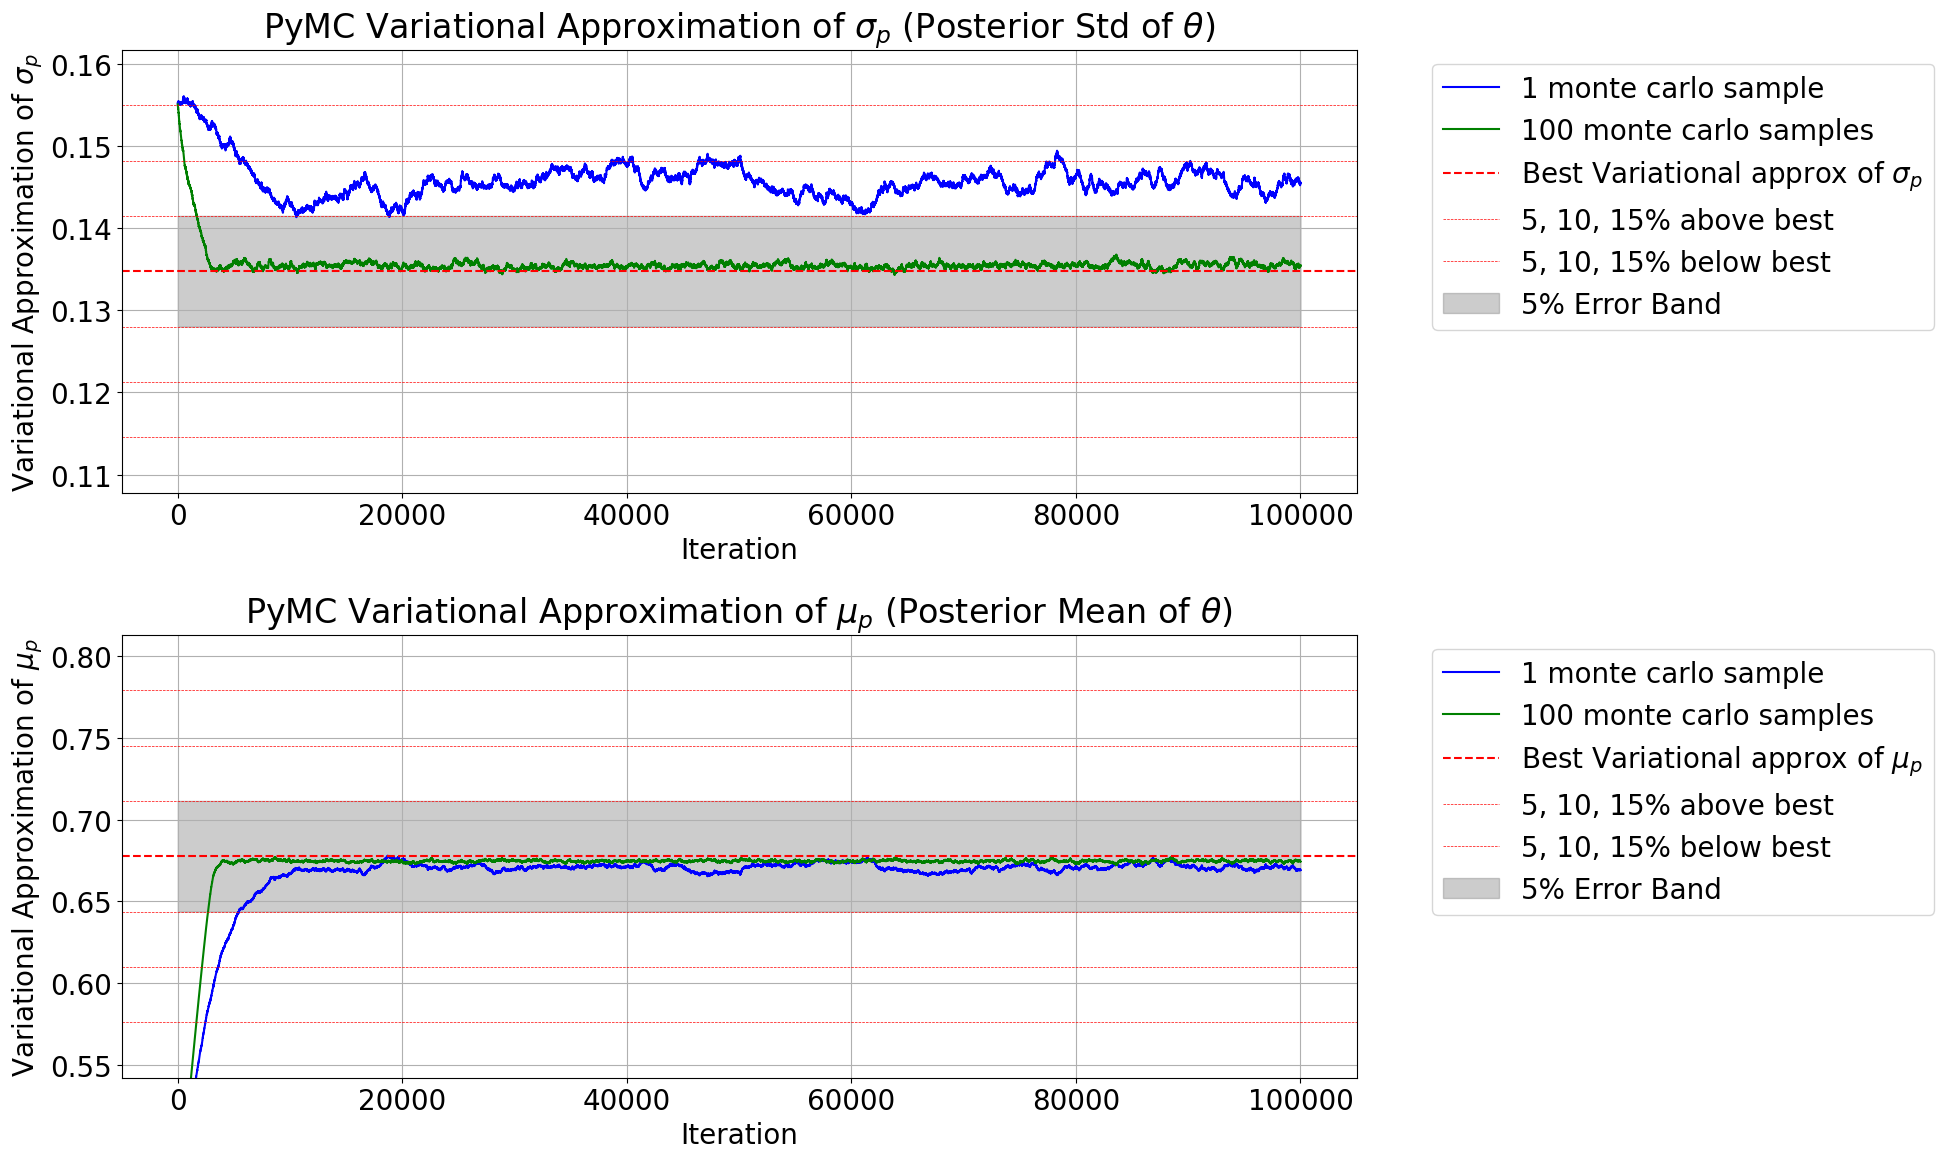

In [5]:
single_mus, single_stds = _trace_locscale_to_theta_moments(
    single_mus_unc, single_stds_unc, n_samples=50_000, seed=1
)
multi_mus, multi_stds = _trace_locscale_to_theta_moments(
    multi_mus_unc, multi_stds_unc, n_samples=50_000, seed=1
)

single_mus = np.array(single_mus)
single_stds = np.array(single_stds)
multi_mus = np.array(multi_mus)
multi_stds = np.array(multi_stds)
# If you have "best" from config, these should be on theta-scale (0,1)
best_mu = float(config["best_mean"]) if "config" in globals() and "best_mean" in config else None
best_std = float(config["best_std"]) if "config" in globals() and "best_std" in config else None
best_mu, best_std = _logistic_normal_mean_std_mc(best_mu, best_std, n_samples=50_000, seed=1)

plt.rcParams.update({"font.size": 20})
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Mean(theta) on bottom axis (axs[1])
axs[1].plot(single_mus, label='1 monte carlo sample', color='blue')
axs[1].plot(multi_mus,  label='100 monte carlo samples', color='green')
axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best Variational approx of $\mu_p$')
axs[1].set_title(fr'PyMC Variational Approximation of $\mu_p$ (Posterior Mean of $\theta$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')

# Std(theta) on top axis (axs[0])
axs[0].plot(single_stds, label='1 monte carlo sample', color='blue')
axs[0].plot(multi_stds,  label='100 monte carlo samples', color='green')
axs[0].axhline(best_std, color='red', linestyle='--', label=r'Best Variational approx of $\sigma_p$')
axs[0].set_title(fr'PyMC Variational Approximation of $\sigma_p$ (Posterior Std of $\theta$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

# y-limits (safe clamping for probabilities)
axs[1].set_ylim([max(0.0, best_mu * 0.8),  min(1.0, best_mu * 1.2)])
axs[0].set_ylim([max(0.0, best_std * 0.8), min(0.5, best_std * 1.2)])

# ±5/10/15% bands around best (also clamped)
for i in [5, 10, 15]:
    axs[1].axhline(min(1.0, best_mu * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(max(0.0, best_mu * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(min(0.5, best_std * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(max(0.0, best_std * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_std*0.95, best_std*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()

plt.tight_layout()
plt.show()


Now with a different optimizer, Adam.

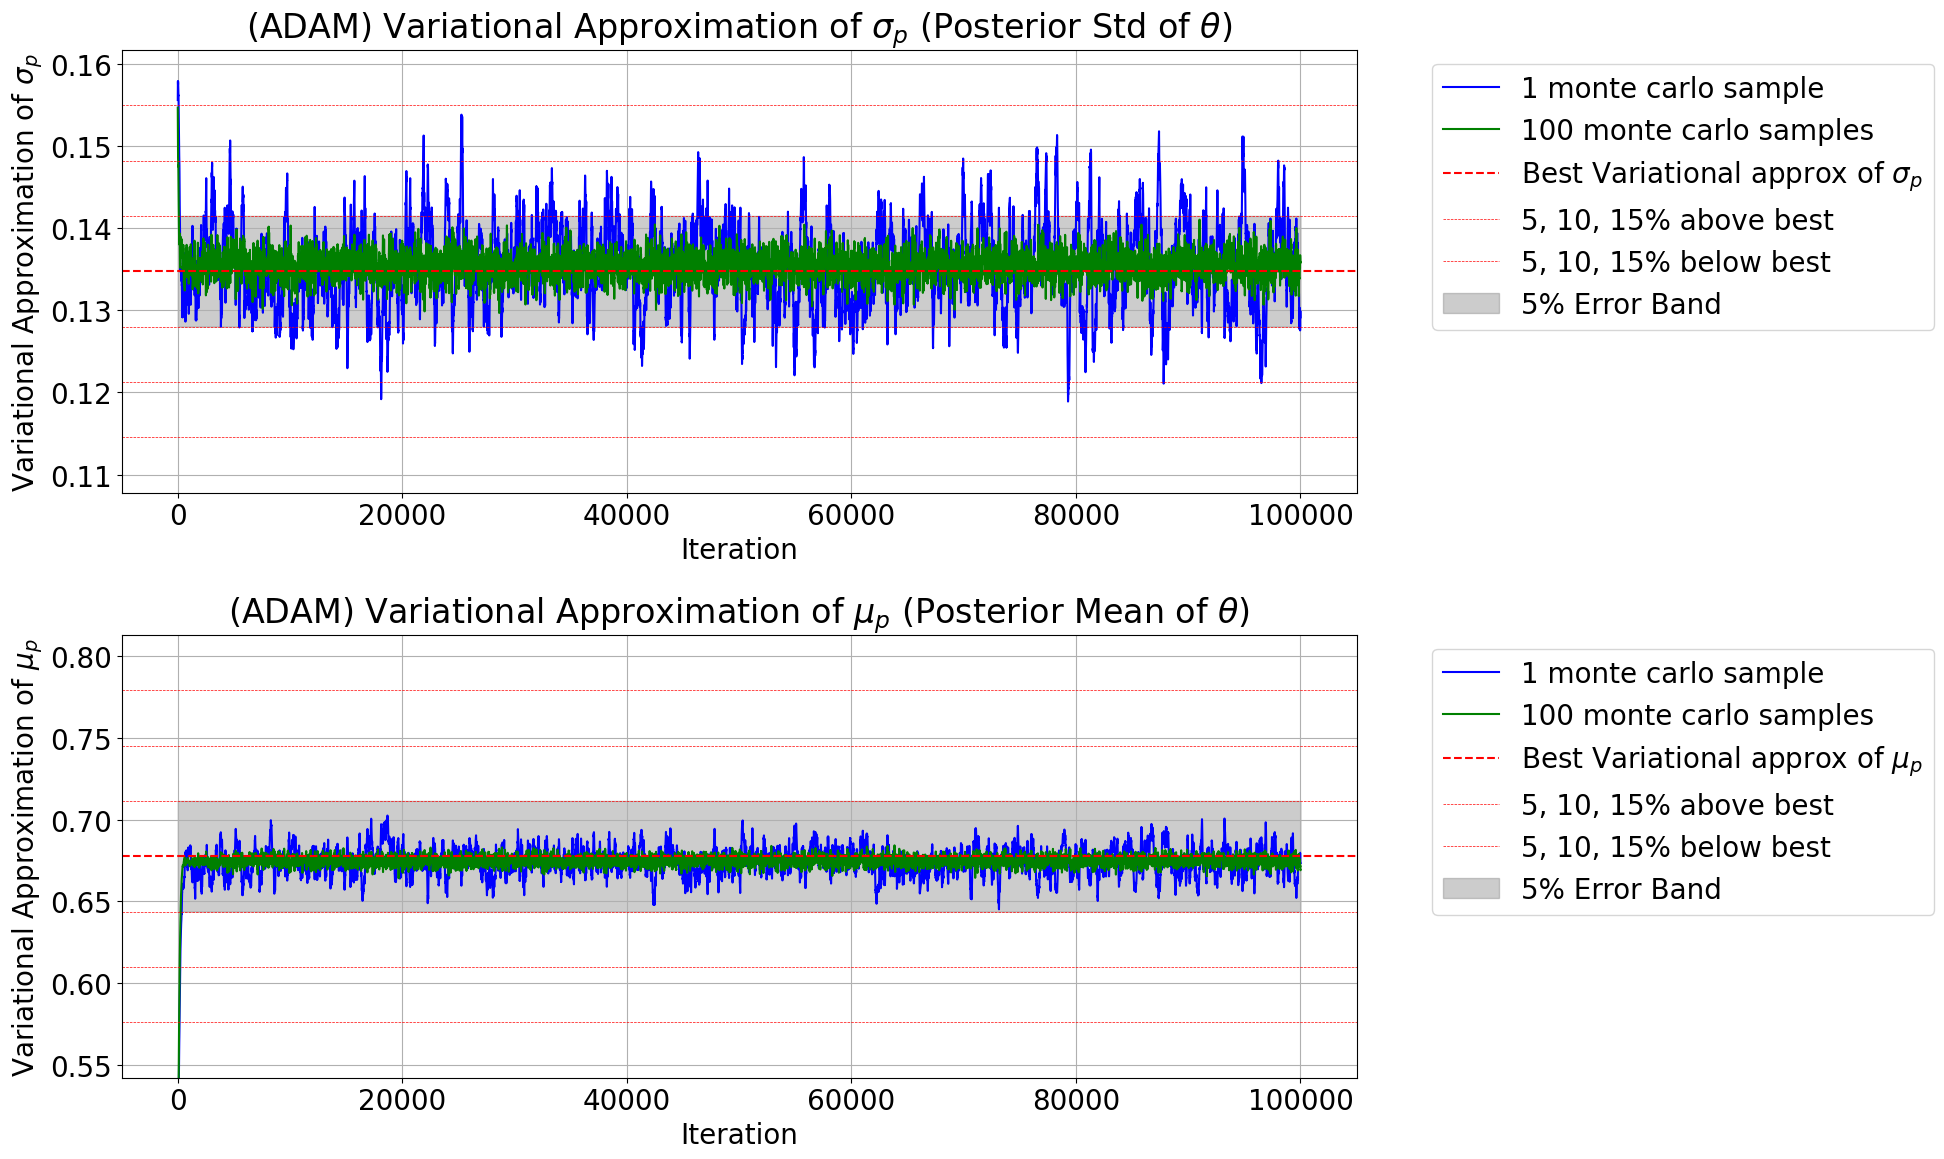

In [6]:
adam_single_mus, adam_single_stds = _trace_locscale_to_theta_moments(
    adam_single_mus_unc, adam_single_stds_unc, n_samples=50_000, seed=1
)
adam_multi_mus, adam_multi_stds = _trace_locscale_to_theta_moments(
    adam_multi_mus_unc, adam_multi_stds_unc, n_samples=50_000, seed=1
)

adam_single_mus = np.array(adam_single_mus)
adam_single_stds = np.array(adam_single_stds)
adam_multi_mus = np.array(adam_multi_mus)
adam_multi_stds = np.array(adam_multi_stds)

plt.rcParams.update({"font.size": 20})
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Mean(theta) on bottom axis (axs[1])
axs[1].plot(adam_single_mus, label='1 monte carlo sample', color='blue')
axs[1].plot(adam_multi_mus,  label='100 monte carlo samples', color='green')
axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best Variational approx of $\mu_p$')
axs[1].set_title(fr'(ADAM) Variational Approximation of $\mu_p$ (Posterior Mean of $\theta$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')

# Std(theta) on top axis (axs[0])
axs[0].plot(adam_single_stds, label='1 monte carlo sample', color='blue')
axs[0].plot(adam_multi_stds,  label='100 monte carlo samples', color='green')
axs[0].axhline(best_std, color='red', linestyle='--', label=r'Best Variational approx of $\sigma_p$')
axs[0].set_title(fr'(ADAM) Variational Approximation of $\sigma_p$ (Posterior Std of $\theta$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

# y-limits (safe clamping for probabilities)
axs[1].set_ylim([max(0.0, best_mu * 0.8),  min(1.0, best_mu * 1.2)])
axs[0].set_ylim([max(0.0, best_std * 0.8), min(0.5, best_std * 1.2)])

# ±5/10/15% bands around best (also clamped)
for i in [5, 10, 15]:
    axs[1].axhline(min(1.0, best_mu * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(max(0.0, best_mu * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(min(0.5, best_std * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(max(0.0, best_std * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_std*0.95, best_std*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()

plt.tight_layout()
plt.show()